In [1]:
import numpy as np
import nengo
from nengo.utils.ensemble import tuning_curves
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Code from the previous example
def simulate_ens(mkens, T=1.0, Δt=1e-3, stim=lambda t: np.sin(2.0 * np.pi * t)):
    np.random.seed(4912)
    with nengo.Network() as model:
        # Create our stimulus
        stim = nengo.Node(stim)

        # Create an ensemble with two neurons
        ens = mkens()

        # Feed the stimulus into the ensemble
        nengo.Connection(stim, ens)

        # Record the stimulus and the neural esponse
        p_stim = nengo.Probe(stim, synapse=None)
        p_spikes = nengo.Probe(ens.neurons, synapse=None)

    with nengo.Simulator(model, dt=Δt, progress_bar=None) as sim:
        # Fetch the tuning curves (this is just for visualising
        # the ensemble)   
        tuning_xs, tuning_A = tuning_curves(ens, sim)

        # Run the simulation for a while
        sim.run(1.0)

        # Fetch the discrete time steps and the neurons
        ts = sim.trange()
        xs = sim.data[p_stim]
        A = sim.data[p_spikes]

    # Compute the decoders
    D = np.linalg.lstsq(A, xs, rcond=None)[0]

    return tuning_xs, tuning_A, ts, xs, A, D

def simulate_two_neurons(*args):
    return simulate_ens(lambda: nengo.Ensemble(
        n_neurons=2, dimensions=1,
        encoders = [[1],[-1]],
        intercepts = [-.5, -.5],
        max_rates= [50, 50]), *args)

def simulate_n_neurons(n, *args):
    return simulate_ens(lambda: nengo.Ensemble(
        n_neurons=n, dimensions=1,
        max_rates=nengo.dists.Uniform(50, 100)), *args)

def rasterplot(ax, ts, A):
    N, n = A.shape
    color = matplotlib.cm.get_cmap('tab10')(0)
    for i in range(n):
        for t in ts[np.where(A[:, i] != 0)]:
            ax.plot([t, t], [i + 0.5, i + 1.5], color=color)
    ax.set_ylim(0.5, n + 0.5)
    if n < 5:
        ax.set_yticks(list(range(1, n + 1)))
    else:
        ax.set_yticks(list(range(1, n + 1, int(np.ceil(n / 5)))))

In [3]:
def rasterplot(ax, ts, A):
    N, n = A.shape
    color = matplotlib.cm.get_cmap('tab10')(0)
    for i in range(n):
        for t in ts[np.where(A[:, i] != 0)]:
            ax.plot([t, t], [i + 0.5, i + 1.5], color=color)
    ax.set_ylim(0.5, n + 0.5)
    if n < 5:
        ax.set_yticks(list(range(1, n + 1)))
    else:
        ax.set_yticks(list(range(1, n + 1, int(np.ceil(n / 5)))))

In [4]:
def plot(fn, tuning_xs, tuning_A, ts, xs, A, D):   
    # Plot the tuning curves
    fig, ax = plt.subplots(figsize=(2.5, 3.62))
    ax.plot(tuning_xs, tuning_A)
    ax.set_xlabel('Represented $x$')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Tuning Curves')
    ax.set_ylim(0, None)
    ax.set_xlim(-1, 1)
    fig.savefig("../" + fn + "_tuning_curves.pdf", transparent=True, bbox_inches='tight')

    # Plot the represented value (ideal) and the decoded value
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 3.5))
    rasterplot(ax1, ts, A)
    ax1.set_xlabel('Time $t$')
    ax1.set_ylabel('Neuron index')
    twax = ax1.twinx()
    twax.set_ylim(-1, 1)
    twax.set_ylabel('Input $x(t)$')
    twax.set_yticks([-1, 0, 1])
    twax.plot(ts, xs, 'k--')
    ax1.set_title('Spike trains')

    # Plot the decoded spike train
    ax2.plot(ts, (D.T @ A.T)[0], label="Decoded $\\hat x(t)$")
    ax2.plot(ts, xs, 'k--', label="Ideal $x(t)$")
    ax2.legend()
    ax2.set_xlabel('Time $t$')
    ax2.set_ylabel('Decoded value $\\hat x(t)$')
    ax2.set_title('Decoded output')
    fig.tight_layout(pad=0.5)
    fig.savefig("../" + fn + "_spike_train.pdf", transparent=True, bbox_inches='tight')

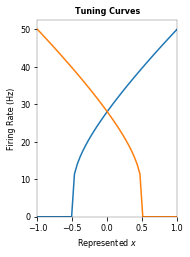

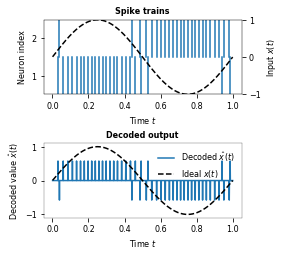

In [5]:
plot("two_neurons", *simulate_two_neurons());

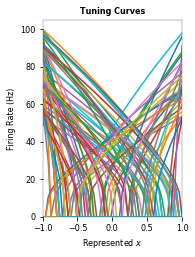

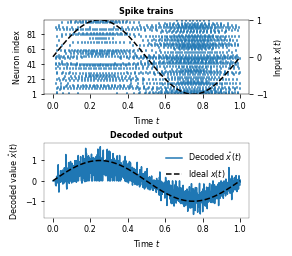

In [6]:
plot("hundred_neurons", *simulate_n_neurons(100));